In [1]:
import sys
from pathlib import Path

# Get the current notebook's directory's parent directory
project_root = Path().resolve().parent.parent

# Add the project root (one level up) to sys.path
sys.path.append(str(project_root))

In [ ]:
import scripts.config as CONF

In [3]:
# use lod env
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Calculate potential index for each wall

The index is combined out of the following factors:
* solid wall area : the estimated area that could be used for greenery for this wall in m². The higher it is, the lower the costs for setting up greenery per m² and the higher the benefit
* window-to-wall ratio (wwr_corrected): the lower the WWR is (fewer windows and doors), the lower the maintenance effort and costs
* orientation: the more south oriented the wall is, the higher the benefit for heat stress reduction

For this:
* the first three factors are scaled to be from 0 to 1, 1 being the best possible value
* an index is built by combining those scaled factors

In [ ]:
# load dataframe with factors
res_df = pd.read_pickle(CONF.dataframes_dir + "df_esults.pkl")    

# define where to find values for index
wwr_column = "wwr_index"
swa_column = "swa_index"
orientation_column = "angle_deg" # angle to north in degrees

In [ ]:
print("mean wwr: ", res_df[wwr_column].mean())
print("mean swa: ", res_df[swa_column].mean())

## Scale main factors 

In [11]:
def plot_hist(data, bins = 50, title = "Histogram", x = "Factor", y = "Number of walls", save_path = None, ylog = False):
    ''' 
    Plots and displays a histogram using the provided data, with an option to save the figure.

    PARAMS:
    * data: A 1D array-like structure containing the data to be plotted in the histogram.
    * bins: (Optional) An integer specifying the number of bins to use for the histogram (default is 50).
    * title: (Optional) A string representing the title of the histogram (default is "Histogram").
    * x: (Optional) A string representing the label for the x-axis (default is "Factor").
    * y: (Optional) A string representing the label for the y-axis (default is "Number of walls").
    * save_path: (Optional) A string representing the file path where the histogram image will be saved. If None, the histogram will not be saved.
    * ylog: (Optional) A boolean indicating whether to use a logarithmic scale for the y-axis (default is False).
    '''
    # make hist
    plt.hist(data, bins = bins, alpha=0.9, edgecolor='black')

    # add title and axis labels
    # set text sizes quite high so that they are still readable if plots are shown rather small in thesis
    #plt.title(title, fontsize = 17)
    plt.xlabel(x, fontsize = 15)
    plt.ylabel(y, fontsize = 15)
    plt.yticks(fontsize = 13)
    plt.xticks(fontsize = 13)

    # x axis should always start with 0
    plt.xlim(0)

    # make y a log scale if wanted
    if ylog:
        plt.yscale('log')

    plt.tight_layout()

    # save figure if wanted
    if save_path is not None:
        plt.savefig(save_path)#, transparent = True)
        
    plt.show()

### Solid wall area

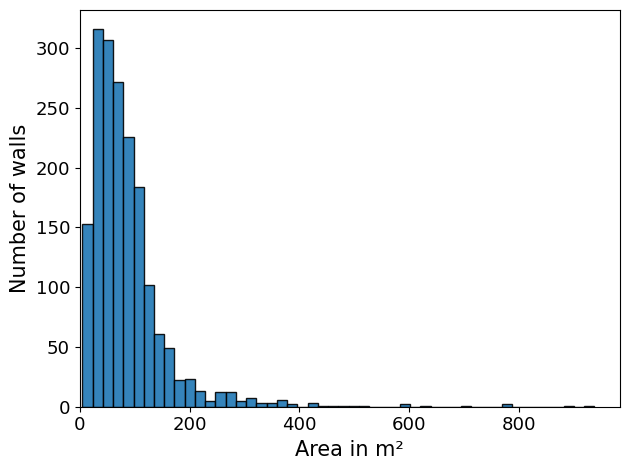

In [ ]:
# look at factor
plot_hist(res_df[swa_column], x = "Area in m²", title = "Solid Wall Area", save_path="swa_orig.png")

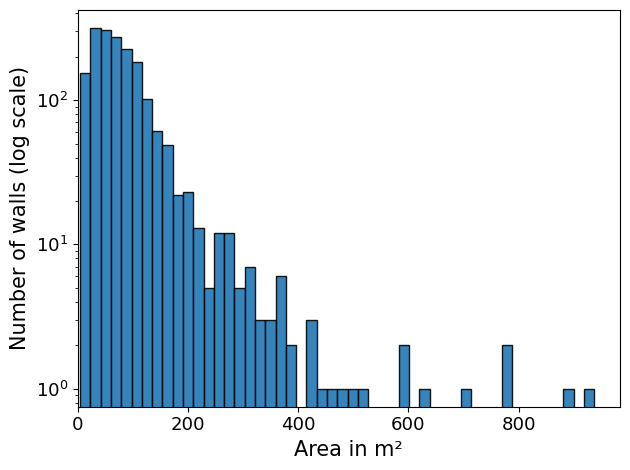

In [ ]:
# look at factor - log
plot_hist(res_df[swa_column], x = "Area in m²", y = "Number of walls (log scale)", title = "Solid Wall Area", save_path="swa_orig_log.png", ylog=True)

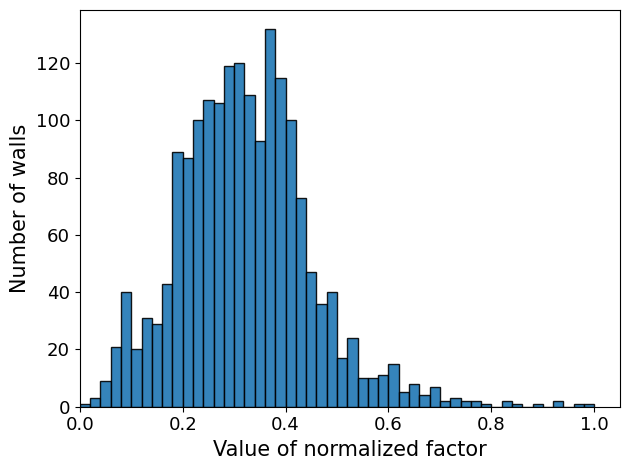

In [ ]:
# the extremes can not stay so extreme, but a log conversion would reduce the values that stand for really good walls for vertical greenery too much, a power transformation with exponent of 0.3 was chosen, followed by a min-max normalisation
solid_wall_area_factor = res_df[res_df]**0.3
solid_wall_area_factor = (solid_wall_area_factor - min(solid_wall_area_factor)) / (max(solid_wall_area_factor) - min(solid_wall_area_factor))
plot_hist(solid_wall_area_factor, x = "Value of normalized factor", title = "Solid Wall Area", save_path="swa_norm.png")

### wwr_corrected

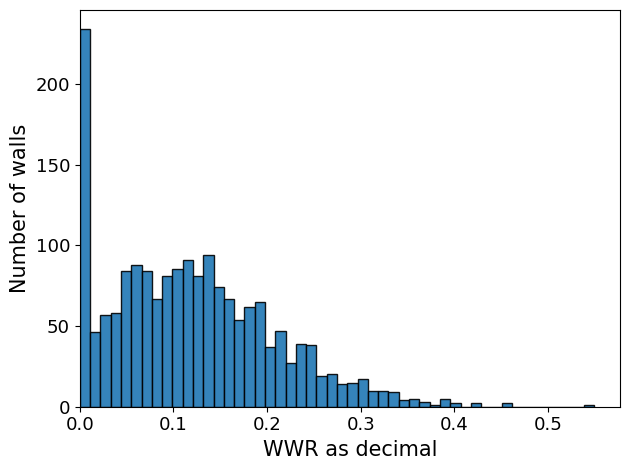

In [ ]:
# look at factor
plot_hist(res_df[wwr_column], x = "WWR as decimal", title = "Window-to-wall ratio", save_path="wwr_orig.png")

In [ ]:
# look at factor
#plot_hist(res_df[wwr_column], x = "WWR as decimal", y = "Number of walls (log scale)", title = "Window-to-wall ratio", save_path=figures_dir + "/wwr_orig_log.png", ylog=True)

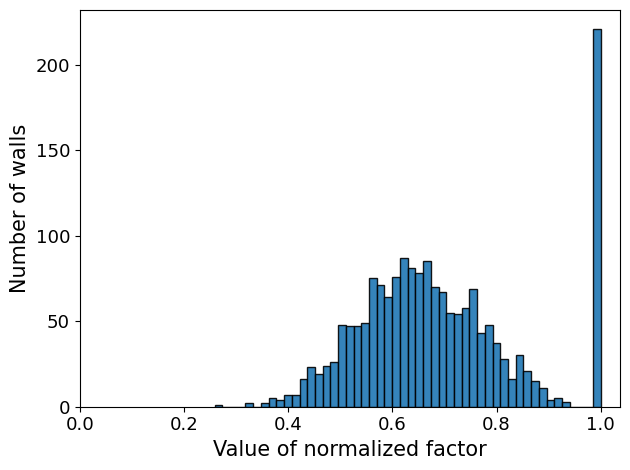

In [ ]:
# take squareroot in order to span the range of most WWRs over a bigger range (-> counts more towards end index)
wwr_factor = res_df[wwr_column]**0.5
# the factor needs to be reversed as a low wwr means a high score
wwr_factor = 1-wwr_factor
plot_hist(wwr_factor, x = "Value of normalized factor", title = "Window-to-wall ratio", save_path="wwr_norm.png")

### orientation

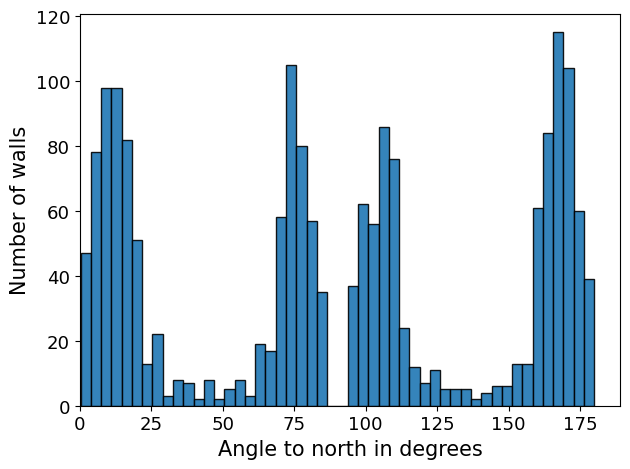

In [ ]:
# look at factor
plot_hist(res_df[orientation_column], x = "Angle to north in degrees", title = "Orientation", save_path="orientation_orig.png")

In [ ]:
# Conditions
conditions = [
    (res_df[orientation_column].between(0, 45)) | (res_df[orientation_column].between(315, 360)),  # North
    res_df[orientation_column].between(45, 135),   # West
    res_df[orientation_column].between(135, 225),  # South
    res_df[orientation_column].between(225, 315)  # East
]

# Corresponding factors
factors = [0.15, 0.35, 0.35, 0.5]

orientation_factor = np.select(conditions, factors, default=np.nan)
#orientation_factor

## Combine into index
Index from multiplication

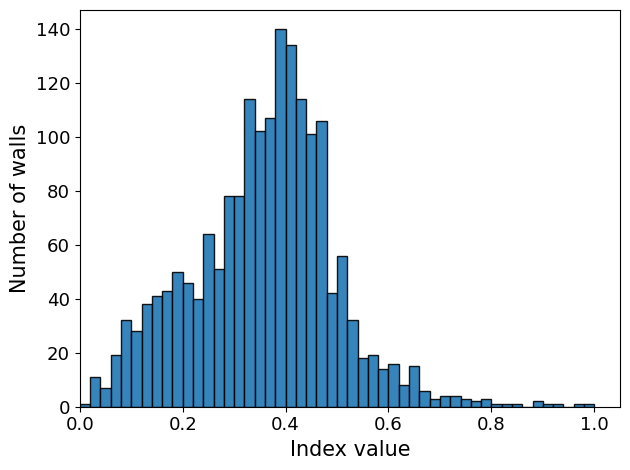

In [21]:
# index is built by multiplying  SSA and WWR and adding factor for orientation
index = (solid_wall_area_factor * wwr_factor) + orientation_factor
index = (index - min(index)) / (max(index) - min(index))

plot_hist(index, x = "Index value", title = "Index", save_path="index.png")

#### index with weighted sum (used in paper)

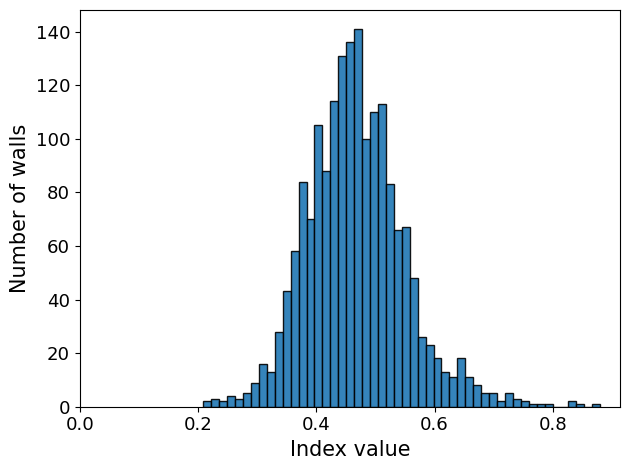

In [ ]:
            # swa, wwr, orientation
w = np.array([0.50, 0.40, 0.1])
F = np.vstack([solid_wall_area_factor, wwr_factor, orientation_factor ]).T  # shape (N, K)

index_ws = F @ w
plot_hist(index_ws, x = "Index value", title = "Index", save_path= "index_weighted.png")

-----------

In [25]:
# add a rank to have something like a priority list, 1 is the wall with the highest potential
index_rank = (pd.Series(index_ws)).rank(ascending = False)
index_rank

0        784.0
1         36.0
2        359.0
3       1021.0
4       1375.0
         ...  
1794     735.0
1795     506.0
1796      57.0
1797     335.0
1798     160.0
Length: 1799, dtype: float64

In [ ]:
# include into df and save
res_df["potential_index"] = index
res_df["potential_rank"] = [int(rank) for rank in index_rank]
res_df.to_csv(CONF.dataframes_dir + "/df_factors_and_potential_index_ws.csv", index = False)

### EXAMPLE
This is example data to see how the output would look like

In [ ]:
top_ten = res_df[res_df["potential_rank"] <=10].sort_values("potential_rank")
top_ten

,index,wall_id,building_id,average_wwr_oblique,average_swa_oblique,fusion_source_oblique,average_wwr_streetview,average_swa_streetview,fusion_source_streetview,average_wwr_fused_combined,average_swa_fused_combined,average_wwr_combined,average_swa_combined,orientation,angle_deg,area,index_wwr,index_swa,potential_index,potential_rank
1044,1517,ID_350510ee-206d-4bd8-9e14-be396ac5e5cd,DENW38AL100008mC,0.0,158.304280,NaN,NaN,NaN,NaN,NaN,NaN,0.0,158.304280,SW,153.681776,158.304280,0.0,158.304280,1.000000,1
1172,1850,combined_2608,DENW38AL100009za,NaN,NaN,NaN,0.0,152.695716,NaN,NaN,NaN,0.0,152.695716,S,161.213360,152.695716,0.0,152.695716,0.979088,2
546,793,ID_9f1fba3a-b092-4a3f-a478-b67c308cb370,DENW38AL10000ABo,0.0,153.442222,oblique,NaN,NaN,NaN,0.0,153.442222,NaN,NaN,E,78.767834,153.442222,0.0,153.442222,0.870120,3
1,1,ID_00a53cf7-3810-40b6-88a0-b786716824d4,DENW38AL10000BEh,0.0,153.143086,oblique,NaN,NaN,NaN,0.0,153.143086,NaN,NaN,E,78.777054,153.143086,0.0,153.143086,0.868993,4
1047,1526,ID_3d4543cd-9580-4459-bb38-42be23254bd6,DENW38AL200007YL,0.0,155.369328,NaN,NaN,NaN,NaN,NaN,NaN,0.0,155.369328,N,12.791461,155.369328,0.0,155.369328,0.728298,5
1159,1833,combined_1087,DENW38AL1000079o,NaN,NaN,NaN,0.0,141.689437,NaN,NaN,NaN,0.0,141.689437,S,167.153664,141.689437,0.0,141.689437,0.936432,6
161,236,ID_2d6718f9-30ad-4c98-b2fa-6feac5235d0a,DENW38AL200004oC,0.0,141.792423,oblique,NaN,NaN,NaN,0.0,141.792423,NaN,NaN,E,77.009114,141.792423,0.0,141.792423,0.825060,7
620,907,ID_b25c2be2-e16b-427d-b685-590112c5fcd2,DENW38AL200007By,0.0,141.091152,oblique,NaN,NaN,NaN,0.0,141.091152,NaN,NaN,E,77.058556,141.091152,0.0,141.091152,0.822266,8
1125,1732,ID_c3219cd8-7f13-44c5-8738-f7f29f22ff0e,DENW38AL200003ZI,0.0,140.740318,NaN,NaN,NaN,NaN,NaN,NaN,0.0,140.740318,E,106.262725,140.740318,0.0,140.740318,0.820865,9
1072,1595,ID_6f8955b6-fe6c-435c-884f-086bfa172186,DENW38AL100007Tu,0.0,137.606461,NaN,NaN,NaN,NaN,NaN,NaN,0.0,137.606461,E,85.168055,137.606461,0.0,137.606461,0.808237,10
